In [9]:
import parser_utils
import data_utils

from sklearn.metrics import roc_curve, auc as auc_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

# config
tf.keras.backend.set_floatx("float32")

ROOT = "/home/ec2-user/biods220/project/assign2"  # Put your root path here

In [2]:
pretrain_target = ['dextrose', 'acetominophen', 'potassium_y', 'insulin', 'heparin', 'statin',
'heart rate', 'glucose', 'hemocrit', 'WBCs', 'temperature (F)', 'creatinine'] # 'SEPSIS' or 'MI' or 'VANCOMYCIN'
x = data_utils.load_seq_dataset(ROOT, pretrain_target)
num_pretrain_labels, pretrain_features = x[5], x[12]
del x

In [12]:
def build_masked_lstm_model(num_timesteps, num_pretrain_features, num_pretrain_labels, 
                            pretrain_feat_mask, pretrain_path = 'pretrained.h5',
                            lstm_hidden_units=256):
    """
    Return a simple Keras model with a masking single LSTM layer, dropout later,
    and then dense prediction layer.

    Args:
    num_timesteps (int): num timesteps per input data object.
    num_features (int): num features per input data object.
    lstm_hidden_units (int): units in the LSTM layer

    Returns:
    model_lstm (tf.keras.Model) LSTM keras model with output dimension (None,1)
    """
    model_pt = tf.keras.Sequential()
    model_pt.add(tf.keras.layers.Masking(mask_value=0, input_shape=(num_timesteps, num_pretrain_features)))
    model_pt.add(tf.keras.layers.LSTM(lstm_hidden_units, return_sequences = True))
    model_pt.add(tf.keras.layers.Dropout(0.5))
    model_pt.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_pretrain_labels)))
    for layer in model_pt.layers[1:]:
        layer.supports_masking = True
    
    if pretrain_path is not None:
        print('LOADING PRETRAINED FEATURES')
        model_pt.load_weights(pretrain_path)
    
    num_features = sum(pretrain_feat_mask)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Masking(mask_value=0, input_shape=(num_timesteps, num_features)))
    model.add(tf.keras.layers.LSTM(lstm_hidden_units, return_sequences = True))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation = 'sigmoid')))
    for layer in model.layers[1:]:
        layer.supports_masking = True

    transfer_weights = model_pt.layers[1].trainable_weights
    transfer_weights[0] = tf.boolean_mask(transfer_weights[0], pretrain_feat_mask)
    model.layers[1].set_weights(transfer_weights)
    return model


def run_experiment(target, label_frac = 1, pretrain = False):
    (
        train_x,
        val_x,
        train_y,
        val_y,
        no_feature_cols,
        no_label_cols,
        test_x,
        test_y,
        x_boolmat_test,
        y_boolmat_test,
        x_boolmat_val,
        y_boolmat_val,
        features,
        labels,
    ) = data_utils.load_seq_dataset(ROOT, target)

    train_ind = int(label_frac * len(train_x))
    
    # convert all float64 to float32
    train_x = train_x.astype(np.float32)[:train_ind]
    val_x = val_x.astype(np.float32)
    test_x = test_x.astype(np.float32)
    train_y = train_y.astype(np.float32)[:train_ind]
    val_y = val_y.astype(np.float32)
    test_y = test_y.astype(np.float32)
    
    print('RUNNING EXPERIMENT FOR {} with label_frac: {} and pretrain: {}'.format(target, label_frac, pretrain))

    print("train shapes ", train_x.shape, train_y.shape)
    print("val shapes   ", val_x.shape, val_y.shape)
    print("test shapes  ", test_x.shape, test_y.shape)
    
    pretrain_feat_mask = [True if x in features else False for x in pretrain_features]
    pretrain_path = 'pretrained.h5' if pretrain else None
    model = build_masked_lstm_model(train_x.shape[-2], len(pretrain_features), num_pretrain_labels, 
                                    pretrain_feat_mask, pretrain_path)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', 
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC (curve='ROC', name='AUROC')
        ],
    )

    epochs = 10
    batch_size = 16
    history = model.fit(
        x = train_x,
        y = train_y,
        epochs = epochs, 
        validation_data = (val_x, val_y),
        callbacks = [tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]
    )
    test_y_pred = model.predict(test_x)
    y_pred_masked = test_y_pred[~y_boolmat_test]
    y_true_masked = test_y[~y_boolmat_test]
#     return y_pred_masked, y_true_masked
    fpr, tpr, thresholds = roc_curve(y_true_masked, y_pred_masked)
    auc = auc_function(fpr, tpr)
    return auc


results = pd.DataFrame(columns = ['condition', 'label fraction', 'pretrain', 'auroc'])
for target in ['SEPSIS', 'VANCOMYCIN', 'MI']:
    for label_frac in [0.01, 0.1, 1]:
        for pretrain in [True, False]:
            new_results = {'condition': [target], 'label fraction': [label_frac], 'pretrain': [pretrain], 'auroc': [run_experiment(target, label_frac, pretrain)]}
            results = pd.concat([results, pd.DataFrame(new_results)])
            
results

RUNNING EXPERIMENT FOR SEPSIS with label_frac: 0.01 and pretrain: True
train shapes  (29, 15, 226) (29, 15, 1)
val shapes    (5178, 15, 226) (5178, 15, 1)
test shapes   (10355, 15, 226) (10355, 15, 1)
LOADING PRETRAINED FEATURES
Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.4116 - accuracy: 0.5820 - AUROC: 0.5704 - val_loss: 0.3354 - val_accuracy: 0.7722 - val_AUROC: 0.3806
Epoch 2/10
1/1 [==============================] - 1s 535ms/step - loss: 0.3281 - accuracy: 0.7930 - AUROC: 0.6504 - val_loss: 0.2911 - val_accuracy: 0.8737 - val_AUROC: 0.2782
Epoch 3/10
1/1 [==============================] - 1s 542ms/step - loss: 0.2836 - accuracy: 0.8555 - AUROC: 0.4893 - val_loss: 0.2521 - val_accuracy: 0.9428 - val_AUROC: 0.2354
Epoch 4/10
1/1 [==============================] - 1s 540ms/step - loss: 0.2469 - accuracy: 0.8984 - AUROC: 0.3847 - val_loss: 0.2172 - val_accuracy: 0.9810 - val_AUROC: 0.2207
Epoch 5/10
1/1 [==============================] - 1s 541ms/step - loss

LOADING PRETRAINED FEATURES
Epoch 1/10
93/93 [==============================] - 6s 29ms/step - loss: 0.1436 - accuracy: 0.9251 - AUROC: 0.7980 - val_loss: 0.0273 - val_accuracy: 0.9926 - val_AUROC: 0.9597
Epoch 2/10
93/93 [==============================] - 1s 13ms/step - loss: 0.0975 - accuracy: 0.9387 - AUROC: 0.9343 - val_loss: 0.0217 - val_accuracy: 0.9907 - val_AUROC: 0.9746
Epoch 3/10
93/93 [==============================] - 1s 12ms/step - loss: 0.0827 - accuracy: 0.9458 - AUROC: 0.9558 - val_loss: 0.0149 - val_accuracy: 0.9919 - val_AUROC: 0.9780
Epoch 4/10
93/93 [==============================] - 1s 12ms/step - loss: 0.0752 - accuracy: 0.9498 - AUROC: 0.9633 - val_loss: 0.0157 - val_accuracy: 0.9905 - val_AUROC: 0.9814
Epoch 5/10
93/93 [==============================] - 1s 12ms/step - loss: 0.0680 - accuracy: 0.9557 - AUROC: 0.9704 - val_loss: 0.0163 - val_accuracy: 0.9900 - val_AUROC: 0.9836
Epoch 6/10
93/93 [==============================] - 1s 12ms/step - loss: 0.0609 - accur

Epoch 1/10
91/91 [==============================] - 6s 26ms/step - loss: 0.2905 - accuracy: 0.7489 - AUROC: 0.7969 - val_loss: 0.2224 - val_accuracy: 0.8109 - val_AUROC: 0.8686
Epoch 2/10
91/91 [==============================] - 1s 13ms/step - loss: 0.2401 - accuracy: 0.8087 - AUROC: 0.8739 - val_loss: 0.2080 - val_accuracy: 0.8275 - val_AUROC: 0.8850
Epoch 3/10
91/91 [==============================] - 1s 12ms/step - loss: 0.2179 - accuracy: 0.8338 - AUROC: 0.8985 - val_loss: 0.2036 - val_accuracy: 0.8360 - val_AUROC: 0.8892
Epoch 4/10
91/91 [==============================] - 1s 12ms/step - loss: 0.2021 - accuracy: 0.8480 - AUROC: 0.9132 - val_loss: 0.2043 - val_accuracy: 0.8391 - val_AUROC: 0.8898
Epoch 5/10
91/91 [==============================] - 1s 12ms/step - loss: 0.1873 - accuracy: 0.8596 - AUROC: 0.9261 - val_loss: 0.2049 - val_accuracy: 0.8363 - val_AUROC: 0.8913
Epoch 6/10
91/91 [==============================] - 1s 12ms/step - loss: 0.1698 - accuracy: 0.8774 - AUROC: 0.9403 

Epoch 4/10
1/1 [==============================] - 1s 536ms/step - loss: 0.2592 - accuracy: 0.8614 - AUROC: 0.8457 - val_loss: 0.2325 - val_accuracy: 0.9875 - val_AUROC: 0.6367
Epoch 5/10
1/1 [==============================] - 1s 540ms/step - loss: 0.2354 - accuracy: 0.8317 - AUROC: 0.8708 - val_loss: 0.2123 - val_accuracy: 0.9880 - val_AUROC: 0.6803
Epoch 6/10
1/1 [==============================] - 1s 540ms/step - loss: 0.2245 - accuracy: 0.8614 - AUROC: 0.8578 - val_loss: 0.1963 - val_accuracy: 0.9872 - val_AUROC: 0.7231
Epoch 7/10
1/1 [==============================] - 1s 539ms/step - loss: 0.2015 - accuracy: 0.8911 - AUROC: 0.9163 - val_loss: 0.1842 - val_accuracy: 0.9838 - val_AUROC: 0.7593
Epoch 8/10
1/1 [==============================] - 1s 533ms/step - loss: 0.1684 - accuracy: 0.8911 - AUROC: 0.9689 - val_loss: 0.1751 - val_accuracy: 0.9761 - val_AUROC: 0.7852
Epoch 9/10
1/1 [==============================] - 1s 537ms/step - loss: 0.1705 - accuracy: 0.8812 - AUROC: 0.9414 - val_

38/38 [==============================] - 1s 21ms/step - loss: 0.1730 - accuracy: 0.8608 - AUROC: 0.9151 - val_loss: 0.0870 - val_accuracy: 0.9271 - val_AUROC: 0.9009
Epoch 6/10
38/38 [==============================] - 1s 21ms/step - loss: 0.1616 - accuracy: 0.8701 - AUROC: 0.9273 - val_loss: 0.0974 - val_accuracy: 0.9112 - val_AUROC: 0.9036
Epoch 7/10
324/324 [==============================] - 2s 2ms/step
RUNNING EXPERIMENT FOR MI with label_frac: 1 and pretrain: False
train shapes  (1192, 15, 222) (1192, 15, 1)
val shapes    (5178, 15, 222) (5178, 15, 1)
test shapes   (10355, 15, 222) (10355, 15, 1)
Epoch 1/10
38/38 [==============================] - 5s 53ms/step - loss: 0.2306 - accuracy: 0.7971 - AUROC: 0.8292 - val_loss: 0.1068 - val_accuracy: 0.8752 - val_AUROC: 0.8928
Epoch 2/10
38/38 [==============================] - 1s 21ms/step - loss: 0.1972 - accuracy: 0.8316 - AUROC: 0.8837 - val_loss: 0.0891 - val_accuracy: 0.9059 - val_AUROC: 0.8946
Epoch 3/10
38/38 [====================

,condition,label fraction,pretrain,auroc
0,SEPSIS,0.01,True,0.35322
0,SEPSIS,0.01,False,0.716565
0,SEPSIS,0.1,True,0.932246
0,SEPSIS,0.1,False,0.906688
0,SEPSIS,1,True,0.986281
0,SEPSIS,1,False,0.99418
0,VANCOMYCIN,0.01,True,0.834079
0,VANCOMYCIN,0.01,False,0.798657
0,VANCOMYCIN,0.1,True,0.8861
0,VANCOMYCIN,0.1,False,0.884464


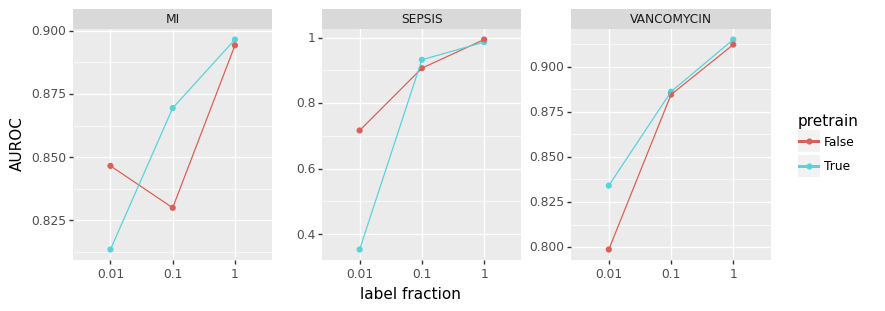

<ggplot: (8741979651319)>

In [34]:
from plotnine import *

import pandas as pd

df = results
df['auroc'] = pd.to_numeric(df['auroc'], errors = 'coerce')

g_plot = (
    ggplot(aes(x = 'label fraction', y = 'auroc', colour = 'pretrain', group = 'pretrain'))
    + geom_point(df)
    + geom_line(df) 
    + scale_y_continuous(name = 'AUROC')
    + facet_wrap(' ~ condition', scales = 'free')
     + theme(figure_size=(9, 3), panel_spacing_x = 0.5)  # here you define the plot size
)
g_plot